In [1]:
import torch
import matplotlib.pyplot as plt
from torch_sampling import reservoir_sampling

# Checking non-contiguous tensors

In [2]:
x = torch.arange(10)
y = x[::3]
for t in [x, y]:
    print(t.is_contiguous())

True
False


In [3]:
k=3
for _ in range(5):
    print(reservoir_sampling(y, k))

tensor([0, 3, 6])
tensor([0, 3, 9])
tensor([0, 3, 6])
tensor([0, 3, 9])
tensor([9, 3, 6])


In [4]:
x = torch.arange(10).cuda()
y = x[::3]
for t in [x, y]:
    print(t.is_contiguous())

True
False


In [5]:
k=3
for _ in range(5):
    print(reservoir_sampling(y, k))

tensor([0, 3, 6], device='cuda:0')
tensor([9, 3, 6], device='cuda:0')
tensor([0, 9, 6], device='cuda:0')
tensor([0, 3, 9], device='cuda:0')
tensor([0, 3, 9], device='cuda:0')


# Check performance for multi-d tensors

In [6]:
x = torch.arange(10**4).view(-1, 2)
n = x.size(0)
k = 3
idx = torch.arange(n)

In [7]:
%timeit x[torch.randperm(n)[:k]]

92 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
%timeit x[reservoir_sampling(idx, k)]

32.9 µs ± 59 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Checking the performance

In [9]:
x = torch.arange(10**4)

# Case 1: k big

In [10]:
k = 9000

In [11]:
%timeit reservoir_sampling(x, k)

76 µs ± 72.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%timeit x[torch.randperm(x.numel())[:k]]

238 µs ± 421 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Case 2: k small

In [13]:
k = 100

In [14]:
%timeit reservoir_sampling(x, k)

23.8 µs ± 71.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%timeit x[torch.randperm(x.numel())[:k]]

173 µs ± 49.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Case 3: k medium

In [16]:
k = 4500

In [17]:
%timeit reservoir_sampling(x, k)

132 µs ± 69.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit x[torch.randperm(x.numel())[:k]]

208 µs ± 168 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# CUDA vs CPU

In [19]:
x_cpu = torch.arange(10**7)
x_cuda = x_cpu.cuda()
k = 10**4

In [20]:
%timeit reservoir_sampling(x_cpu, k)

23.7 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit reservoir_sampling(x_cuda, k)

8.73 ms ± 6.75 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Checking distributions

In [22]:
x = torch.arange(10)

### CPU Extension

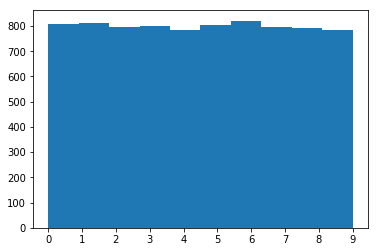

In [23]:
k = 8
samples = []
for _ in range(1000):
    samples.extend(reservoir_sampling(x, k).numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

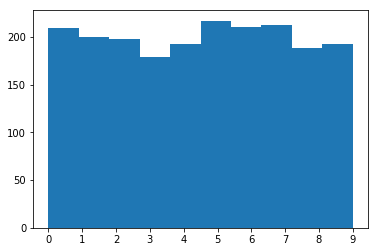

In [24]:
k = 2
samples = []
for _ in range(1000):
    samples.extend(reservoir_sampling(x, k).numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

### CUDA Extension

In [25]:
x = x.cuda()

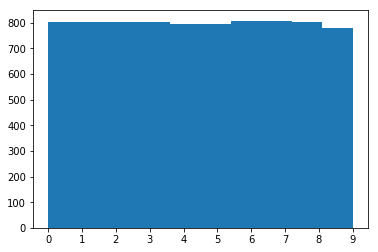

In [26]:
k = 8
samples = []
for _ in range(1000):
    samples.extend(reservoir_sampling(x, k).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

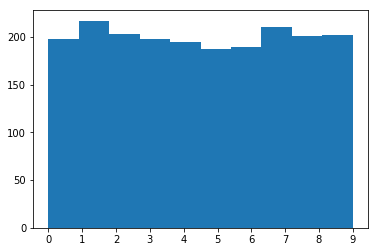

In [27]:
k = 2
samples = []
for _ in range(1000):
    samples.extend(reservoir_sampling(x, k).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()